# Zombie Detection

In this project I use the Object Detection API and retrain [RetinaNet](https://arxiv.org/abs/1708.02002) to spot Zombies using just 5 training images. I setup the model to restore pretrained weights and fine tune the classification layers.

<img src='zombie.jpeg' alt='zombie'>

## Installation

I start by installing the Tensorflow 2 [Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection).

In [ ]:

!rm -rf ./models/

# clone the Tensorflow Model Garden
!git clone --depth 1 https://github.com/tensorflow/models/

Cloning into 'models'...
remote: Enumerating objects: 4360, done.
remote: Counting objects: 100% (4360/4360), done.
remote: Compressing objects: 100% (3178/3178), done.
remote: Total 4360 (delta 1185), reused 3982 (delta 1109), pack-reused 0 (from 0)
Receiving objects: 100% (4360/4360), 69.98 MiB | 33.41 MiB/s, done.
Resolving deltas: 100% (1185/1185), done.


In [3]:
# For compatibility. Pin tf-models-official version so it will use Tensorflow 2.15.
!sed -i 's/tf-models-official>=2.5.1/tf-models-official==2.15.0/g' ./models/research/object_detection/packages/tf2/setup.py

# Compile the Object Detection API protocol buffers and install the necessary packages
!cd models/research/ && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install .

Processing /content/models/research
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.0/152.0 kB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of pymilvus to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This coul

In [4]:
# Downgrade protobuf for compatibility. You can ignore dependency conflicts in the output.
!pip install protobuf==3.20

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 4.2 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.8
    Uninstalling protobuf-4.25.8:
      Successfully uninstalled protobuf-4.25.8
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.67.0 requires protobuf!=4.0.*,!=4.21.*,!=4.22.0,!=4.23.*,!=4.24.*,<6.0.0.dev0,>=3.20.3, but you have protobuf 3.20.0 which is incompatible.
tensorflow 2.15.1 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 3.20.0 which is incompatible.
google-cloud-dataproc 5.21.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<7.0.0,>=3.20.2, but you have protobuf 3.20.0 which is incompatible.
google-cloud-resource-manager 1.14.2 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4

**IMPORTANT**: I should restart the runtime for the changes to take effect.

## Imports

In [1]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import zipfile
import io
import scipy.misc
import numpy as np

import glob
import imageio
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
tf.get_logger().setLevel('ERROR')

/tmp/ipython-input-4202210303.py:8: DeprecationWarning: scipy.misc is deprecated and will be removed in 2.0.0
  import scipy.misc


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.



### Import Object Detection API packages

Here I import the necessary modules from the `object_detection` package.
- From the [utils](https://github.com/tensorflow/models/tree/master/research/object_detection/utils) package:
  - [label_map_util](https://github.com/tensorflow/models/blob/master/research/object_detection/utils/label_map_util.py)
  - [config_util](https://github.com/tensorflow/models/blob/master/research/object_detection/utils/config_util.py): I use this to read model configurations from a .config file and then modify that configuration
  - [visualization_utils](https://github.com/tensorflow/models/blob/master/research/object_detection/utils/visualization_utils.py): I give this the alias `viz_utils`, as this is what will be used in some visualization code later.
  - [colab_utils](https://github.com/tensorflow/models/blob/master/research/object_detection/utils/colab_utils.py)
- From the [builders](https://github.com/tensorflow/models/tree/master/research/object_detection/builders) package:
  - [model_builder](https://github.com/tensorflow/models/blob/master/research/object_detection/builders/model_builder.py): This builds my model according to the model configuration that I'll specify.

In [ ]:
# import the label map utility module
from object_detection.utils import label_map_util

# import module for reading and updating configuration files.
from object_detection.utils import config_util

# import module for visualization. use the alias `viz_utils`
from object_detection.utils import visualization_utils as viz_utils

# import module for building the detection model
from object_detection.builders import model_builder

# import module for utilities in Colab
# from object_detection.utils import colab_utils

## Utilities

Here I define a couple of utility functions for loading images and plotting detections.

In [3]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
    path: a file path.

    Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
    """

    img_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(img_data))
    (im_width, im_height) = image.size

    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)


def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
    """Wrapper function to visualize detections.

    Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
          and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
          this function assumes that the boxes to be plotted are groundtruth
          boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
          category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
    """

    image_np_with_annotations = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_annotations,
        boxes,
        classes,
        scores,
        category_index,
        use_normalized_coordinates=True,
        min_score_thresh=0.8)

    if image_name:
        plt.imsave(image_name, image_np_with_annotations)

    else:
        plt.imshow(image_np_with_annotations)


## Download the Zombie data

Now I get 5 images of zombies that I will use for training.
- The zombies are hosted in a Google bucket.
- I download and unzip the images into a local `training/` directory by running the cell below.

In [ ]:
# uncomment the next 2 lines if want to delete an existing zip and training directory
# !rm training-zombie.zip
# !rm -rf ./training

# download the images
!wget --no-check-certificate \
    https://storage.googleapis.com/tensorflow-3-public/datasets/training-zombie.zip \
    -O ./training-zombie.zip

# unzip to a local directory
local_zip = './training-zombie.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./training')
zip_ref.close()

--2025-08-14 11:51:02--  https://storage.googleapis.com/tensorflow-3-public/datasets/training-zombie.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.202.207, 74.125.69.207, 64.233.181.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.202.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1915446 (1.8M) [application/zip]
Saving to: ‘./training-zombie.zip’

./training-zombie.z 100%[===================>]   1.83M  --.-KB/s    in 0.01s   

2025-08-14 11:51:03 (182 MB/s) - ‘./training-zombie.zip’ saved [1915446/1915446]



### Visualize the training images

Next, I want to inspect the images that were just downloaded.

* The paths for the images look like this:

```
./training/training-zombie1.jpg
./training/training-zombie2.jpg
./training/training-zombie3.jpg
./training/training-zombie4.jpg
./training/training-zombie5.jpg
```
- To set file paths, I use [os.path.join](https://www.geeksforgeeks.org/python-os-path-join-method/).  As an example, if I wanted to create the path './parent_folder/file_name1.txt', I could write:

`os.path.join('parent_folder', 'file_name' + str(1) + '.txt')`

./training/training-zombie1.jpg
./training/training-zombie2.jpg
./training/training-zombie3.jpg
./training/training-zombie4.jpg
./training/training-zombie5.jpg


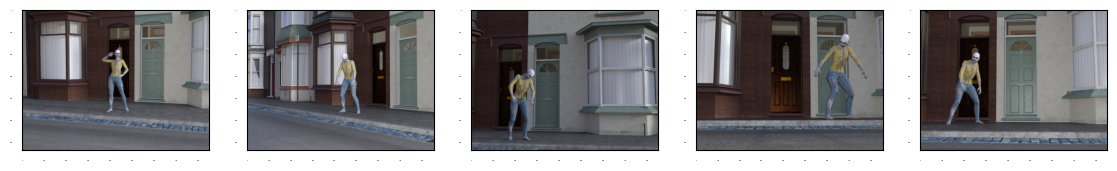

In [6]:
%matplotlib inline

# assign the name (string) of the directory containing the training images
train_image_dir = './training'

# declare an empty list
train_images_np = []

# run a for loop for each image
for i in range(1, 6):

    # define the path (string) for each image
    image_path = os.path.join(train_image_dir,  "training-zombie" + str(i) + '.jpg')
    print(image_path)

    # load images into numpy arrays and append to a list
    train_images_np.append(load_image_into_numpy_array(image_path))

# configure plot settings via rcParams
plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

# plot images
for idx, train_image_np in enumerate(train_images_np):
    plt.subplot(1, 5, idx+1)
    plt.imshow(train_image_np)

plt.show()


## Prepare data for training

In this section, I create ground truth boxes. I draw my own boxes, but I also have prepopulated list of coordinates.


In [7]:
# Define the list of ground truth boxes
gt_boxes = []

#### Option 1: I draw my own ground truth boxes

* I draw a box around the zombie in each image.
* Click the `next image` button to go to the next image
* Click `submit` when it says "All images completed!!".

In [ ]:
# Option 1: draw ground truth boxes

# annotate the training images
colab_utils.annotate(train_images_np, box_storage_pointer=gt_boxes)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

In [ ]:
# Option 1: here I draw my own ground truth boxes
# TEST CODE:
try:
  assert(len(gt_boxes) == 5), "Warning: gt_boxes is empty. Did you click `submit`?"

except AssertionError as e:
  print(e)

# checks if there are boxes for all 5 images
for gt_box in gt_boxes:
    try:
      assert(gt_box is not None), "There are less than 5 sets of box coordinates. " \
                                  "Please re-run the cell above to draw the boxes again.\n" \
                                  "Alternatively, you can run the next cell to load pre-determined " \
                                  "ground truth boxes."

    except AssertionError as e:
        print(e)
        break


ref_gt_boxes = [
        np.array([[0.27333333, 0.41500586, 0.74333333, 0.57678781]]),
        np.array([[0.29833333, 0.45955451, 0.75666667, 0.61078546]]),
        np.array([[0.40833333, 0.18288394, 0.945, 0.34818288]]),
        np.array([[0.16166667, 0.61899179, 0.8, 0.91910903]]),
        np.array([[0.28833333, 0.12543962, 0.835, 0.35052755]]),
      ]

for gt_box, ref_gt_box in zip(gt_boxes, ref_gt_boxes):
    try:
      assert(np.allclose(gt_box, ref_gt_box, atol=0.04)), "One of the boxes is too big or too small. " \
                                                          "Please re-draw and make the box tighter around the zombie."

    except AssertionError as e:
      print(e)
      break


#### Option 2: I could also use the given ground truth boxes

In [ ]:
# # Option 2: use given ground truth boxes
# # set this to `True` if want to override the boxes you drew
# override = False

# # bounding boxes for each of the 5 zombies found in each image.
# # I could use these instead of drawing the boxes myself.
# ref_gt_boxes = [
#         np.array([[0.27333333, 0.41500586, 0.74333333, 0.57678781]]),
#         np.array([[0.29833333, 0.45955451, 0.75666667, 0.61078546]]),
#         np.array([[0.40833333, 0.18288394, 0.945, 0.34818288]]),
#         np.array([[0.16166667, 0.61899179, 0.8, 0.91910903]]),
#         np.array([[0.28833333, 0.12543962, 0.835, 0.35052755]]),
#       ]

# # if gt_boxes is empty, use the reference
# if not gt_boxes or override is True:
#   gt_boxes = ref_gt_boxes

# # if gt_boxes does not contain 5 box coordinates, use the reference
# for gt_box in gt_boxes:
#     try:
#       assert(gt_box is not None)

#     except:
#       gt_boxes = ref_gt_boxes

#       break


#### View ground truth box coordinates

In [ ]:
# print the coordinates of ground truth boxes
for gt_box in gt_boxes:
  print(gt_box)

[[0.27606771 0.41969519 0.74273437 0.57913247]]
[[0.30440104 0.46424385 0.75440104 0.60961313]]
[[0.41606771 0.19460727 0.93440104 0.34349355]]
[[0.16940104 0.62368113 0.78940104 0.9144197 ]]
[[0.29940104 0.12778429 0.82273438 0.34349355]]


Below, I add the class annotations. For simplicity, I assume just a single class, though it should be straightforward to extend this to handle multiple classes. I also convert everything to the format that the training loop expects (e.g., conversion to tensors, one-hot representations, etc.).

### Define the category index dictionary

I need to tell the model which integer class ID to assign to the 'zombie' category, and what 'name' to associate with that integer id.

- zombie_class_id: By convention, class ID integers start numbering from 1,2,3, onward.
  - If there is ever a 'background' class, it could be assigned the integer 0, but in this case, I'm just predicting the one zombie class.
  - Since I'm just predicting one class (zombie), I assign `1` to the zombie class ID.

- category_index: I define the `category_index` dictionary, which will have the following structure:
```
category_index = {zombie_class_id :
{'id'  : zombie_class_id,
 'name': 'zombie'}
}
```

- num_classes: Since I'm predicting one class, I assign `1` to the number of classes that the model will predict.
  - This will be used during data preprocessing and again when I configure the model.


In [16]:

# Assign the zombie class ID
zombie_class_id = 1

# define a dictionary describing the zombie class
category_index = {zombie_class_id :
{'id'  : zombie_class_id,
 'name': 'zombie'}
}

# Specify the number of classes that the model will predict
num_classes = 1

In [17]:
# TEST CODE:

print(category_index[zombie_class_id])

{'id': 1, 'name': 'zombie'}


### Data preprocessing
I now do some data preprocessing so it is formatted properly before it is fed to the model:
- Convert the class labels to one-hot representations
- convert everything (i.e. train images, gt boxes and class labels) to tensors.


In [ ]:
# The `label_id_offset` here shifts all classes by a certain number of indices;
# I do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index.  This is ordinarily just handled
# automatically in my training binaries, but I need to reproduce it here.

label_id_offset = 1
train_image_tensors = []

# lists containing the one-hot encoded classes and ground truth boxes
gt_classes_one_hot_tensors = []
gt_box_tensors = []

for (train_image_np, gt_box_np) in zip(train_images_np, gt_boxes):

    # convert training image to tensor, add batch dimension, and add to list
    train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
        train_image_np, dtype=tf.float32), axis=0))

    # convert numpy array to tensor, then add to list
    gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))

    # apply offset to to have zero-indexed ground truth classes
    zero_indexed_groundtruth_classes = tf.convert_to_tensor(
        np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)

    # do one-hot encoding to ground truth classes
    gt_classes_one_hot_tensors.append(tf.one_hot(
        zero_indexed_groundtruth_classes, num_classes))

print('Done prepping data.')

Done prepping data.


## Visualize the zombies with their ground truth bounding boxes

I want to see the 5 training images with the bounding boxes.


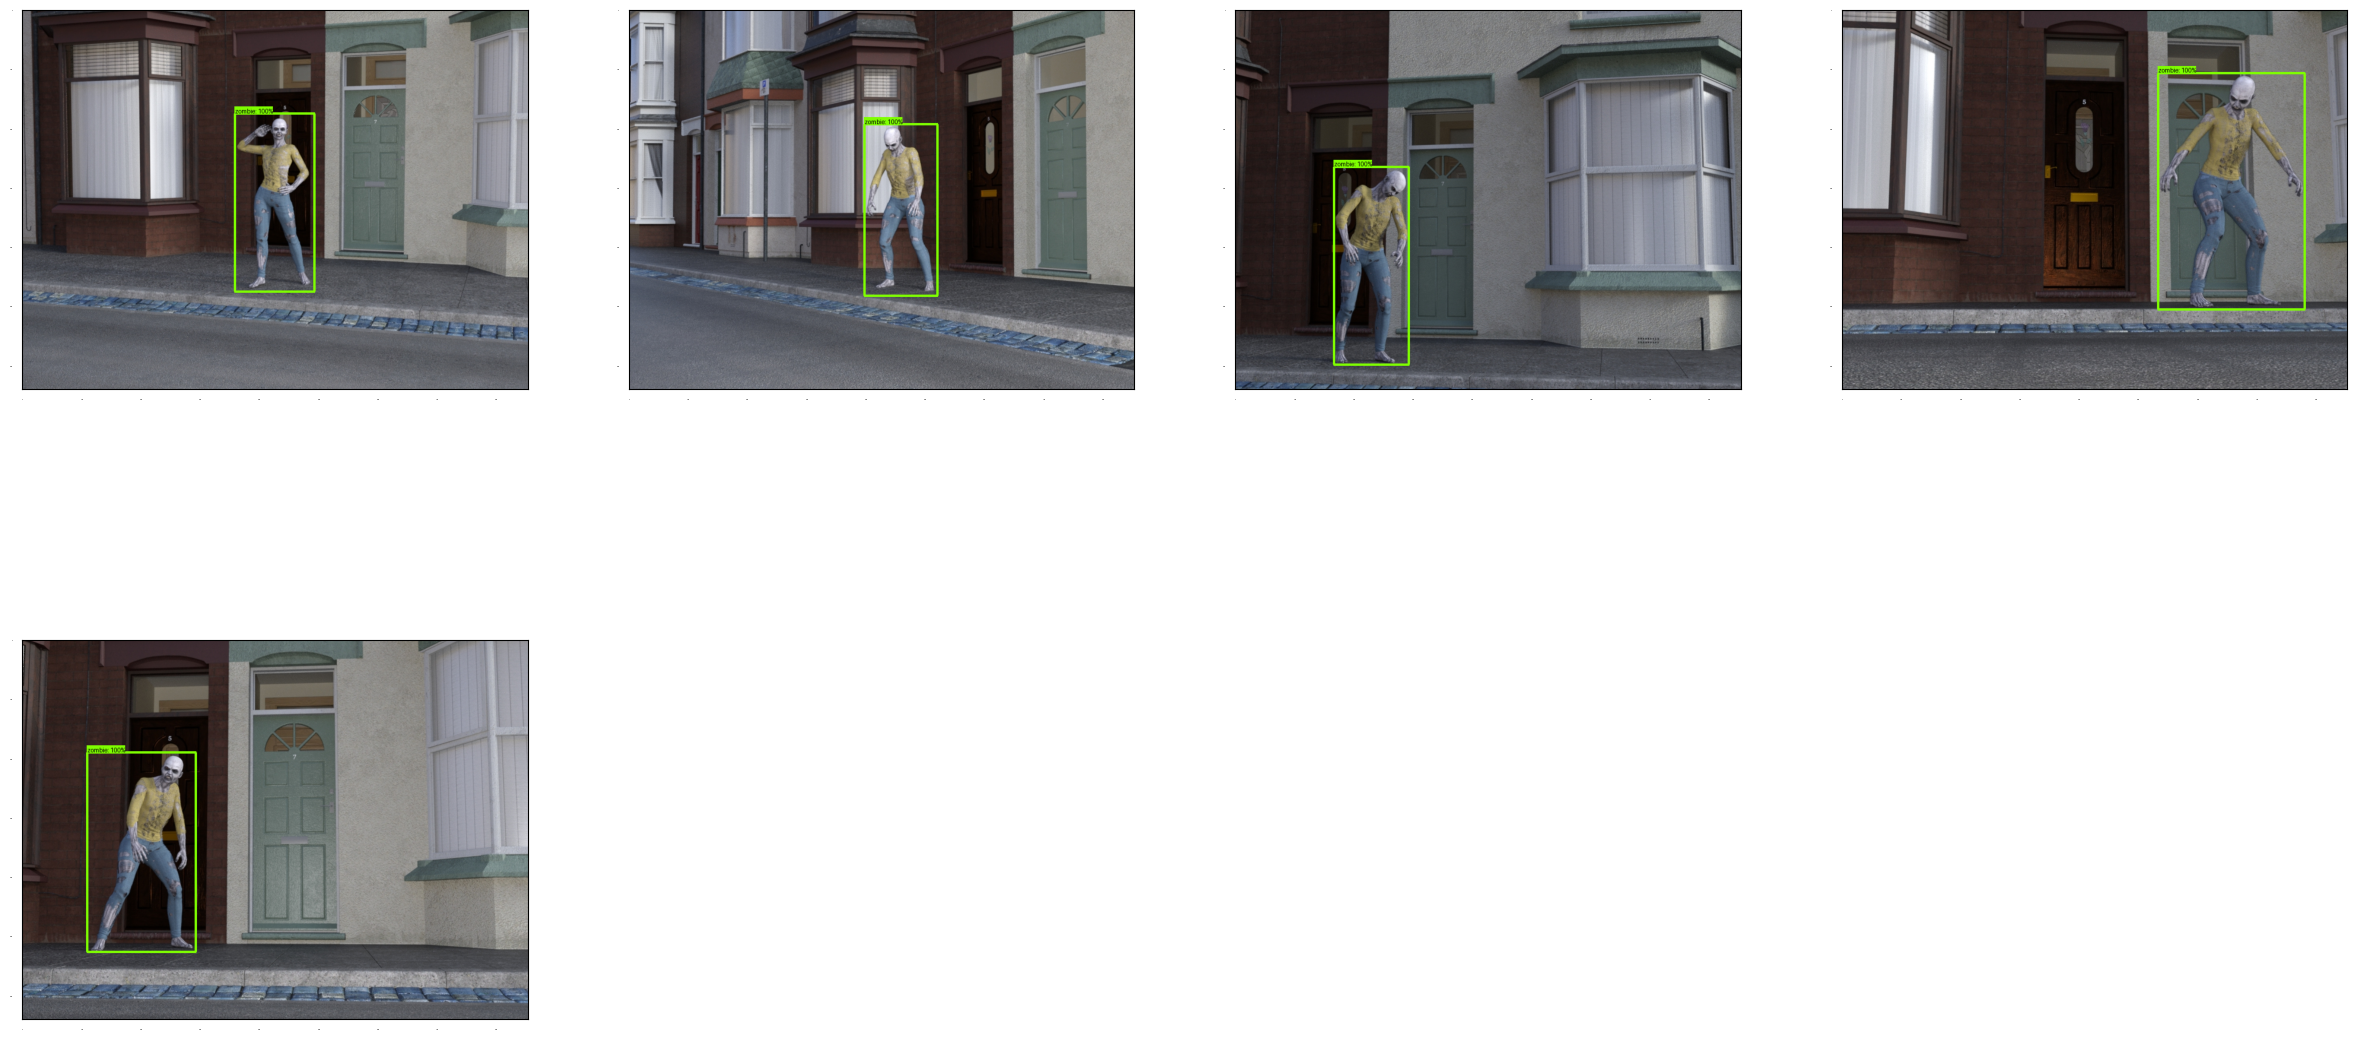

In [19]:
# give boxes a score of 100%
dummy_scores = np.array([1.0], dtype=np.float32)

# define the figure size
plt.figure(figsize=(30, 15))

# use the `plot_detections()` utility function to draw the ground truth boxes
for idx in range(5):
    plt.subplot(2, 4, idx+1)
    plot_detections(
      train_images_np[idx],
      gt_boxes[idx],
      np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),
      dummy_scores, category_index)

plt.show()

## Download the checkpoint containing the pre-trained weights

Next, you I download [RetinaNet](https://arxiv.org/abs/1708.02002) and copy it inside the object detection directory.



### Download checkpoints

  - I download the compressed SSD Resnet 50 version 1, 640 x 640 checkpoint.
  - Untar (decompress) the tar file
  - Move the decompressed checkpoint to `models/research/object_detection/test_data/`


In [20]:
import os, shutil, tarfile, urllib.request, pathlib

# 1) Source: TF2 Detection Model Zoo (linked from the TF blog)
CKPT_URL = "http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz"

# Filenames/paths
archive_name = CKPT_URL.split("/")[-1]
extract_root = "tmp_ckpt_extract"  # temp dir
target_root = os.path.join("models", "research", "object_detection", "test_data")

# 2) Download
print("Downloading:", CKPT_URL)
urllib.request.urlretrieve(CKPT_URL, archive_name)
print("Saved to:", archive_name)

# 3) Extract
os.makedirs(extract_root, exist_ok=True)
with tarfile.open(archive_name, "r:gz") as tar:
    tar.extractall(extract_root)

# Find top-level folder created by the tar (should be ssd_resnet50_v1_fpn_640x640_coco17_tpu-8)
candidates = [p for p in pathlib.Path(extract_root).iterdir() if p.is_dir()]
if not candidates:
    raise RuntimeError("Could not find extracted checkpoint directory.")
src_dir = str(candidates[0])

# 4) Move to models/research/object_detection/test_data/
os.makedirs(target_root, exist_ok=True)
dst_dir = os.path.join(target_root, os.path.basename(src_dir))
if os.path.exists(dst_dir):
    shutil.rmtree(dst_dir)  # replace if it already exists
shutil.move(src_dir, dst_dir)

print("Checkpoint moved to:", dst_dir)
print("Contents:", os.listdir(dst_dir))


Downloading: http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Saved to: ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Checkpoint moved to: models/research/object_detection/test_data/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8
Contents: ['saved_model', 'checkpoint', 'pipeline.config']


## Configure the model
Here, I configure the model for this use case.

### Locate and read from the configuration file

#### configs
If to look at the module [config_util](https://github.com/tensorflow/models/blob/master/research/object_detection/utils/config_util.py) that was imported, it contains the following function:

```
def get_configs_from_pipeline_file(pipeline_config_path, config_override=None):
```
- I use this function to load the configuration from your `pipeline_config`.
  - `configs` will now contain a dictionary.


In [21]:
tf.keras.backend.clear_session()

# define the path to the .config file for ssd resnet 50 v1 640x640
pipeline_config = "models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config"

# Load the configuration file into a dictionary
configs = config_util.get_configs_from_pipeline_file(pipeline_config)

# See what configs looks like
configs

{'model': ssd {
   num_classes: 90
   image_resizer {
     fixed_shape_resizer {
       height: 640
       width: 640
     }
   }
   feature_extractor {
     type: "ssd_resnet50_v1_fpn_keras"
     depth_multiplier: 1.0
     min_depth: 16
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 0.0004
         }
       }
       initializer {
         truncated_normal_initializer {
           mean: 0.0
           stddev: 0.03
         }
       }
       activation: RELU_6
       batch_norm {
         decay: 0.997
         scale: true
         epsilon: 0.001
       }
     }
     override_base_feature_extractor_hyperparams: true
     fpn {
       min_level: 3
       max_level: 7
     }
   }
   box_coder {
     faster_rcnn_box_coder {
       y_scale: 10.0
       x_scale: 10.0
       height_scale: 5.0
       width_scale: 5.0
     }
   }
   matcher {
     argmax_matcher {
       matched_threshold: 0.5
       unmatched_threshold: 0.5
       ignore_thresholds: fa

### Get the model configuration

#### model_config
- From the `configs` dictionary, access the object associated with the key 'model'.
- `model_config` now contains an object of type `object_detection.protos.model_pb2.DetectionModel`.  


In [22]:

# Read in the object stored at the key 'model' of the configs dictionary
model_config = configs['model']


# see what model_config looks like
model_config


ssd {
  num_classes: 90
  image_resizer {
    fixed_shape_resizer {
      height: 640
      width: 640
    }
  }
  feature_extractor {
    type: "ssd_resnet50_v1_fpn_keras"
    depth_multiplier: 1.0
    min_depth: 16
    conv_hyperparams {
      regularizer {
        l2_regularizer {
          weight: 0.0004
        }
      }
      initializer {
        truncated_normal_initializer {
          mean: 0.0
          stddev: 0.03
        }
      }
      activation: RELU_6
      batch_norm {
        decay: 0.997
        scale: true
        epsilon: 0.001
      }
    }
    override_base_feature_extractor_hyperparams: true
    fpn {
      min_level: 3
      max_level: 7
    }
  }
  box_coder {
    faster_rcnn_box_coder {
      y_scale: 10.0
      x_scale: 10.0
      height_scale: 5.0
      width_scale: 5.0
    }
  }
  matcher {
    argmax_matcher {
      matched_threshold: 0.5
      unmatched_threshold: 0.5
      ignore_thresholds: false
      negatives_lower_than_unmatched: true
      force_


### Modify model_config
- Here I freeze batch normalization by setting the relevant field to `True`.

In [ ]:
# assumes `num_classes` was defined earlier
model_config.ssd.num_classes = num_classes

# freeze batch norm during fine-tuning
model_config.ssd.freeze_batchnorm = True

# See what model_config now looks like after I've customized it
model_config

ssd {
  num_classes: 1
  image_resizer {
    fixed_shape_resizer {
      height: 640
      width: 640
    }
  }
  feature_extractor {
    type: "ssd_resnet50_v1_fpn_keras"
    depth_multiplier: 1.0
    min_depth: 16
    conv_hyperparams {
      regularizer {
        l2_regularizer {
          weight: 0.0004
        }
      }
      initializer {
        truncated_normal_initializer {
          mean: 0.0
          stddev: 0.03
        }
      }
      activation: RELU_6
      batch_norm {
        decay: 0.997
        scale: true
        epsilon: 0.001
      }
    }
    override_base_feature_extractor_hyperparams: true
    fpn {
      min_level: 3
      max_level: 7
    }
  }
  box_coder {
    faster_rcnn_box_coder {
      y_scale: 10.0
      x_scale: 10.0
      height_scale: 5.0
      width_scale: 5.0
    }
  }
  matcher {
    argmax_matcher {
      matched_threshold: 0.5
      unmatched_threshold: 0.5
      ignore_thresholds: false
      negatives_lower_than_unmatched: true
      force_m

## Build the model

I imported [model_builder](https://github.com/tensorflow/models/blob/master/research/object_detection/builders/model_builder.py).  
- I use `model_builder` to build the model according to the configurations that I have just downloaded and customized.


### Build the custom model

#### model_builder
model_builder has a function `build`:

```
def build(model_config, is_training, add_summaries=True):

```

In [24]:

detection_model = model_builder.build(model_config=model_config, is_training=True)### END CODE HERE ###

print(type(detection_model))

<class 'object_detection.meta_architectures.ssd_meta_arch.SSDMetaArch'>


## Restore weights from checkpoint

Now, I selectively restore weights from my checkpoint.
- My end goal is to create a custom model which reuses parts of, but not all of the layers of RetinaNet (currently stored in the variable `detection_model`.)
  - The parts of RetinaNet that I want to reuse are:
    - Feature extraction layers
    - Bounding box regression prediction layer
  - The part of RetinaNet that I will not want to reuse is the classification prediction layer (since I will define and train my own classification layer specific to zombies).
  - For the parts of RetinaNet that I want to reuse, I also restore the weights from the checkpoint that I selected.

#### Inspect the detection_model
First, let's take a look at the type of the detection_model and its Python class.

In [ ]:
# check the type of detection_model
detection_model

In [26]:
vars(detection_model)

{'_self_setattr_tracking': True,
 '_obj_reference_counts_dict': ObjectIdentityDictionary({<_ObjectIdentityWrapper wrapping False>: 4, <_ObjectIdentityWrapper wrapping 1>: 1, <_ObjectIdentityWrapper wrapping DictWrapper({})>: 1, <_ObjectIdentityWrapper wrapping True>: 7, <_ObjectIdentityWrapper wrapping <object_detection.anchor_generators.multiscale_grid_anchor_generator.MultiscaleGridAnchorGenerator object at 0x782826618190>>: 1, <_ObjectIdentityWrapper wrapping <object_detection.predictors.convolutional_keras_box_predictor.WeightSharedConvolutionalBoxPredictor object at 0x7828266877d0>>: 1, <_ObjectIdentityWrapper wrapping <object_detection.box_coders.faster_rcnn_box_coder.FasterRcnnBoxCoder object at 0x78282682a710>>: 1, <_ObjectIdentityWrapper wrapping <object_detection.models.ssd_resnet_v1_fpn_keras_feature_extractor.SSDResNet50V1FpnKerasFeatureExtractor object at 0x78282654da10>>: 1, <_ObjectIdentityWrapper wrapping 'ResNet50V1_FPN'>: 1, <_ObjectIdentityWrapper wrapping <tf.Tensor

In [27]:
# view the type of _box_predictor
detection_model._box_predictor

In [28]:
vars(detection_model._box_predictor)

{'_self_setattr_tracking': True,
 '_obj_reference_counts_dict': ObjectIdentityDictionary({<_ObjectIdentityWrapper wrapping False>: 5, <_ObjectIdentityWrapper wrapping True>: 3, <_ObjectIdentityWrapper wrapping 1>: 1, <_ObjectIdentityWrapper wrapping <object_detection.predictors.heads.keras_box_head.WeightSharedConvolutionalBoxHead object at 0x7828267d89d0>>: 1, <_ObjectIdentityWrapper wrapping DictWrapper({'class_predictions_with_background': <object_detection.predictors.heads.keras_class_head.WeightSharedConvolutionalClassHead object at 0x78285827e890>})>: 1, <_ObjectIdentityWrapper wrapping ListWrapper(['class_predictions_with_background'])>: 1, <_ObjectIdentityWrapper wrapping <object_detection.builders.hyperparams_builder.KerasLayerHyperparams object at 0x7828266b6510>>: 1, <_ObjectIdentityWrapper wrapping 256>: 1, <_ObjectIdentityWrapper wrapping 4>: 1, <_ObjectIdentityWrapper wrapping 3>: 1, <_ObjectIdentityWrapper wrapping ListWrapper([])>: 1, <_ObjectIdentityWrapper wrapping Di

### Define Checkpoints for the box predictor

- I define `box_predictor_checkpoint` to be checkpoint for these two layers of the `detection_model`'s box predictor:
  - The base tower layer (the layers the precede both the class prediction and bounding box prediction layers).
  - The box prediction head (the prediction layer for bounding boxes).
- Note, I won't include the class prediction layer.


In [29]:
tmp_box_predictor_checkpoint = tf.train.Checkpoint(
    _base_tower_layers_for_heads = detection_model._box_predictor._base_tower_layers_for_heads,
    _box_prediction_head         = detection_model._box_predictor._box_prediction_head
)

In [ ]:
# Check the datatype of this checkpoint
type(tmp_box_predictor_checkpoint)


tensorflow.python.checkpoint.checkpoint.Checkpoint

In [31]:
# Check the variables of this checkpoint
vars(tmp_box_predictor_checkpoint)

{'_root': None,
 '_self_setattr_tracking': True,
 '_self_unconditional_checkpoint_dependencies': [TrackableReference(name=_base_tower_layers_for_heads, ref={'box_encodings': ListWrapper([]), 'class_predictions_with_background': ListWrapper([])}),
  TrackableReference(name=_box_prediction_head, ref=<object_detection.predictors.heads.keras_box_head.WeightSharedConvolutionalBoxHead object at 0x7828267d89d0>)],
 '_self_unconditional_dependency_names': {'_base_tower_layers_for_heads': {'box_encodings': ListWrapper([]),
   'class_predictions_with_background': ListWrapper([])},
  '_box_prediction_head': <object_detection.predictors.heads.keras_box_head.WeightSharedConvolutionalBoxHead at 0x7828267d89d0>},
 '_self_unconditional_deferred_dependencies': {},
 '_self_update_uid': -1,
 '_self_name_based_restores': set(),
 '_self_saveable_object_factories': {},
 '_kwargs': {'_base_tower_layers_for_heads': {'box_encodings': ListWrapper([]),
   'class_predictions_with_background': ListWrapper([])},
  


### Define the temporary model checkpoint

Now I define `tmp_model_checkpoint` so that it points to these two layers:
- The feature extractor of the detection model.
- The temporary box predictor checkpoint that I just defined.


In [32]:
tmp_model_checkpoint = tf.train.Checkpoint(
    _feature_extractor = detection_model._feature_extractor,
    _box_predictor     = tmp_box_predictor_checkpoint
)

In [ ]:
# Check the datatype of this checkpoint
type(tmp_model_checkpoint)


tensorflow.python.checkpoint.checkpoint.Checkpoint

In [34]:
# Check the vars of this checkpoint
vars(tmp_model_checkpoint)

{'_root': None,
 '_self_setattr_tracking': True,
 '_self_unconditional_checkpoint_dependencies': [TrackableReference(name=_box_predictor, ref=<tensorflow.python.checkpoint.checkpoint.Checkpoint object at 0x782826449950>),
  TrackableReference(name=_feature_extractor, ref=<object_detection.models.ssd_resnet_v1_fpn_keras_feature_extractor.SSDResNet50V1FpnKerasFeatureExtractor object at 0x78282654da10>)],
 '_self_unconditional_dependency_names': {'_box_predictor': <tensorflow.python.checkpoint.checkpoint.Checkpoint at 0x782826449950>,
  '_feature_extractor': <object_detection.models.ssd_resnet_v1_fpn_keras_feature_extractor.SSDResNet50V1FpnKerasFeatureExtractor at 0x78282654da10>},
 '_self_unconditional_deferred_dependencies': {},
 '_self_update_uid': -1,
 '_self_name_based_restores': set(),
 '_self_saveable_object_factories': {},
 '_kwargs': {'_feature_extractor': <object_detection.models.ssd_resnet_v1_fpn_keras_feature_extractor.SSDResNet50V1FpnKerasFeatureExtractor at 0x78282654da10>,



### Restore the checkpoint

I can now restore the checkpoint.

First, find and set the `checkpoint_path`

- checkpoint_path:
  - Using the "files" browser, I navigate to `models -> research -> object_detection -> test_data`.
  - Here I see a subfolder named "checkpoint".  
    - The 'checkpoint' folder contains three files:
      - checkpoint
      - ckpt-0.data-00000-of-00001
      - ckpt-0.index
    - I set checkpoint_path to the path to the full path `models/research/object_detection/test_data/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt-0`
      - Notice that I don't want to include a file extension after `ckpt-0`.

Next, I define one last checkpoint using `tf.train.Checkpoint()`.
- For the single keyword argument,
  - I set the key as `model=`
  - I set the value to my temporary model checkpoint that I just defined.

Finally, I call this checkpoint's `.restore()` function, passing in the path to the checkpoint.

In [37]:
# Path to ckpt-0 (NO .index or .data extension)
checkpoint_path = "models/research/object_detection/test_data/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt-0"

# Define a checkpoint that sets `model` to the temporary model checkpoint
checkpoint = tf.train.Checkpoint(model=tmp_model_checkpoint)

# Restore the checkpoint to the checkpoint path
checkpoint.restore(checkpoint_path).expect_partial()


### Run a dummy image to generate the model variables

I run a dummy image through the model so that variables are created. I need to select the trainable variables later and right now it is still empty. 

Recall that `detection_model` is an object of type [object_detection.meta_architectures.ssd_meta_arch.SSDMetaArch]()

Important methods that are available in the `detection_model` object  are:
- [preprocess()](https://github.com/tensorflow/models/blob/dc4d11216b738920ddb136729e3ae71bddb75c7e/research/object_detection/meta_architectures/ssd_meta_arch.py#L459):
    - takes in a tensor representing an image and returns `image, shapes`
    - For the dummy image, I can declare a [tensor of zeros](https://www.tensorflow.org/api_docs/python/tf/zeros) that has a shape that the `preprocess()` method can accept (i.e. [batch, height, width, channels]).
    - my images have dimensions 640 x 640 x 3.
    - I can pass in a batch of 1 when making the dummy image.

- [predict()](https://github.com/tensorflow/models/blob/dc4d11216b738920ddb136729e3ae71bddb75c7e/research/object_detection/meta_architectures/ssd_meta_arch.py#L525)
  - takes in `image, shapes` which are created by the `preprocess()` function call.
  - returns a prediction in a Python dictionary
  - this will pass the dummy image through the forward pass of the network and create the model variables

- [postprocess()](https://github.com/tensorflow/models/blob/dc4d11216b738920ddb136729e3ae71bddb75c7e/research/object_detection/meta_architectures/ssd_meta_arch.py#L655)
  - Takes in the prediction_dict and shapes
  - returns a dictionary of post-processed predictions of detected objects ("detections").
  

In [38]:
# use the detection model's `preprocess()` method and pass a dummy image
tmp_image, tmp_shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3], dtype=tf.float32))

# run a prediction with the preprocessed image and shapes
tmp_prediction_dict = detection_model.predict(tmp_image, tmp_shapes)

# postprocess the predictions into final detections
tmp_detections = detection_model.postprocess(tmp_prediction_dict, tmp_shapes)

print('Weights restored!')

Weights restored!


In [39]:
# Test Code:
assert len(detection_model.trainable_variables) > 0, "Please pass in a dummy image to create the trainable variables."

print(detection_model.weights[0].shape)
print(detection_model.weights[231].shape)
print(detection_model.weights[462].shape)

(3, 3, 256, 24)
(512,)
(256,)


## Eager mode custom training loop

With the data and model now setup, I can now proceed to configure the training.



### Set training hyperparameters

Here I set an appropriate learning rate and optimizer for the training.

- batch_size: I use 5
- num_batches: I use 100
- learning_rate: I use 0.01
- optimizer: I use [tf.keras.optimizers.SGD](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD)
  - Set the learning rate
  - Set the momentum to 0.9
  

In [40]:
tf.keras.backend.set_learning_phase(True)

# set the batch_size
batch_size = 5

# set the number of batches
num_batches = 100

# Set the learning rate
learning_rate = 0.01

# set the optimizer and pass in the learning_rate
optimizer =  tf.keras.optimizers.SGD(
    learning_rate=learning_rate,
    momentum=0.9
)


/usr/local/lib/python3.11/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


## Choose the layers to fine-tune

To make use of transfer learning and pre-trained weights, I train just certain parts of the detection model, namely, the last prediction layers.

In [41]:
# Inspect the layers of detection_model
for i,v in enumerate(detection_model.trainable_variables):
    print(f"i: {i} \t name: {v.name} \t shape:{v.shape} \t dtype={v.dtype}")

i: 0 	 name: WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead/BoxPredictor/kernel:0 	 shape:(3, 3, 256, 24) 	 dtype=<dtype: 'float32'>
i: 1 	 name: WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead/BoxPredictor/bias:0 	 shape:(24,) 	 dtype=<dtype: 'float32'>
i: 2 	 name: WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead/ClassPredictor/kernel:0 	 shape:(3, 3, 256, 12) 	 dtype=<dtype: 'float32'>
i: 3 	 name: WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead/ClassPredictor/bias:0 	 shape:(12,) 	 dtype=<dtype: 'float32'>
i: 4 	 name: WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_0/kernel:0 	 shape:(3, 3, 256, 256) 	 dtype=<dtype: 'float32'>
i: 5 	 name: WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_0/BatchNorm/feature_0/gamma:0 	 shape:(256,) 	 dtype=<dtype: 'float32'>
i: 6 	 name: WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_0/BatchNorm/feature_0/


### Select the prediction layer variables

Based on inspecting the `detection_model.trainable_variables`, I select the prediction layer variables that I fine tune:
- The bounding box head variables (which predict bounding box coordinates)
- The class head variables (which predict the class/category)

I have a few options for doing this:
- I can access them by their list index:
```
detection_model.trainable_variables[92]
```

- Alternatively, I can use string matching to select the variables (I used this option):
```
tmp_list = []
for v in detection_model.trainable_variables:
  if v.name.startswith('ResNet50V1_FPN/bottom_up_block5'):
    tmp_list.append(v)
```

In [ ]:
# define a list that contains the layers that I wish to fine tune
to_fine_tune = []
for v in detection_model.trainable_variables:
  if v.name.startswith('WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead') or v.name.startswith('WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead') :
    to_fine_tune.append(v)


In [51]:
# Test Code:

print(to_fine_tune[0].name)
print(to_fine_tune[2].name)

WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead/BoxPredictor/kernel:0
WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead/ClassPredictor/kernel:0


## Train the model

I define a function that handles training for one batch, which I'll later use in my training loop.


In [ ]:
# Get a batch of my training images
g_images_list = train_image_tensors[0:2]

The `detection_model` is of class [SSDMetaArch](https://github.com/tensorflow/models/blob/dc4d11216b738920ddb136729e3ae71bddb75c7e/research/object_detection/meta_architectures/ssd_meta_arch.py#L655), and its source code shows that is has this function [preprocess](https://github.com/tensorflow/models/blob/dc4d11216b738920ddb136729e3ae71bddb75c7e/research/object_detection/meta_architectures/ssd_meta_arch.py#L459).
- This preprocesses the images so that they can be passed into the model (for training or prediction):
```
  def preprocess(self, inputs):
    """Feature-extractor specific preprocessing.
    ...
    Args:
      inputs: a [batch, height_in, width_in, channels] float tensor representing
        a batch of images with values between 0 and 255.0.
    Returns:
      preprocessed_inputs: a [batch, height_out, width_out, channels] float
        tensor representing a batch of images.
        
      true_image_shapes: int32 tensor of shape [batch, 3] where each row is
        of the form [height, width, channels] indicating the shapes
        of true images in the resized images, as resized images can be padded
        with zeros.
```


In [ ]:
# I use .preprocess to preprocess an image
g_preprocessed_image = detection_model.preprocess(g_images_list[0])
print(f"g_preprocessed_image type: {type(g_preprocessed_image)}")
print(f"g_preprocessed_image length: {len(g_preprocessed_image)}")
print(f"index 0 has the preprocessed image of shape {g_preprocessed_image[0].shape}")
print(f"index 1 has information about the image's true shape excluding padding: {g_preprocessed_image[1]}")

g_preprocessed_image type: <class 'tuple'>
g_preprocessed_image length: 2
index 0 has the preprocessed image of shape (1, 640, 640, 3)
index 1 has information about the image's true shape excluding padding: [[640 640   3]]


I pre-process each image and save their outputs into two separate lists
- One list of the preprocessed images
- One list of the true shape for each preprocessed image

In [54]:
preprocessed_image_list = []
true_shape_list = []

for img in g_images_list:
    processed_img, true_shape = detection_model.preprocess(img)
    preprocessed_image_list.append(processed_img)
    true_shape_list.append(true_shape)

print(f"preprocessed_image_list is of type {type(preprocessed_image_list)}")
print(f"preprocessed_image_list has length {len(preprocessed_image_list)}")
print()
print(f"true_shape_list is of type {type(true_shape_list)}")
print(f"true_shape_list has length {len(true_shape_list)}")

preprocessed_image_list is of type <class 'list'>
preprocessed_image_list has length 2

true_shape_list is of type <class 'list'>
true_shape_list has length 2


## Make a prediction
The `detection_model` also has a `.predict` function.  According to the source code for [predict](https://github.com/tensorflow/models/blob/dc4d11216b738920ddb136729e3ae71bddb75c7e/research/object_detection/meta_architectures/ssd_meta_arch.py#L525)

```
  def predict(self, preprocessed_inputs, true_image_shapes):
    """Predicts unpostprocessed tensors from input tensor.
    This function takes an input batch of images and runs it through the forward
    pass of the network to yield unpostprocessesed predictions.
...
    Args:
      preprocessed_inputs: a [batch, height, width, channels] image tensor.
      
      true_image_shapes: int32 tensor of shape [batch, 3] where each row is
        of the form [height, width, channels] indicating the shapes
        of true images in the resized images, as resized images can be padded
        with zeros.
        
    Returns:
      prediction_dict: a dictionary holding "raw" prediction tensors:
        1) preprocessed_inputs: the [batch, height, width, channels] image
          tensor.
        2) box_encodings: 4-D float tensor of shape [batch_size, num_anchors,
          box_code_dimension] containing predicted boxes.
        3) class_predictions_with_background: 3-D float tensor of shape
          [batch_size, num_anchors, num_classes+1] containing class predictions
          (logits) for each of the anchors.  Note that this tensor *includes*
          background class predictions (at class index 0).
        4) feature_maps: a list of tensors where the ith tensor has shape
          [batch, height_i, width_i, depth_i].
        5) anchors: 2-D float tensor of shape [num_anchors, 4] containing
          the generated anchors in normalized coordinates.
        6) final_anchors: 3-D float tensor of shape [batch_size, num_anchors, 4]
          containing the generated anchors in normalized coordinates.
        If self._return_raw_detections_during_predict is True, the dictionary
        will also contain:
        7) raw_detection_boxes: a 4-D float32 tensor with shape
          [batch_size, self.max_num_proposals, 4] in normalized coordinates.
        8) raw_detection_feature_map_indices: a 3-D int32 tensor with shape
          [batch_size, self.max_num_proposals].
    """
```

Notice that `.predict` takes its inputs as tensors.

In [55]:
# Try to call `predict` and pass in lists; look at the error message
try:
    detection_model.predict(preprocessed_image_list, true_shape_list)
except AttributeError as e:
    print("Error message:", e)

Error message: Exception encountered when calling layer 'ResNet50V1_FPN' (type SSDResNet50V1FpnKerasFeatureExtractor).

'list' object has no attribute 'get_shape'

Call arguments received by layer 'ResNet50V1_FPN' (type SSDResNet50V1FpnKerasFeatureExtractor):
  • inputs=['tf.Tensor(shape=(1, 640, 640, 3), dtype=float32)', 'tf.Tensor(shape=(1, 640, 640, 3), dtype=float32)']
  • kwargs={'training': 'True'}


But I can check how to properly use `predict`:
- Notice that the source code documentation says that `preprocessed_inputs` and `true_image_shapes` are expected to be tensors and not lists of tensors.
- One way to turn a list of tensors into a tensor is to use [tf.concat](https://www.tensorflow.org/api_docs/python/tf/concat)

```
tf.concat(
    values, axis, name='concat'
)
```

In [56]:
# Turn a list of tensors into a tensor
preprocessed_image_tensor = tf.concat(preprocessed_image_list, axis=0)
true_shape_tensor = tf.concat(true_shape_list, axis=0)

print(f"preprocessed_image_tensor shape: {preprocessed_image_tensor.shape}")
print(f"true_shape_tensor shape: {true_shape_tensor.shape}")

preprocessed_image_tensor shape: (2, 640, 640, 3)
true_shape_tensor shape: (2, 3)


Now I can make predictions for the images.
According to the source code, `predict` returns a dictionary containing the prediction information, including:
- The bounding box predictions
- The class predictions

In [57]:
# Make predictions on the images
prediction_dict = detection_model.predict(preprocessed_image_tensor, true_shape_tensor)

print("keys in prediction_dict:")
for key in prediction_dict.keys():
    print(key)

keys in prediction_dict:
preprocessed_inputs
feature_maps
anchors
final_anchors
box_encodings
class_predictions_with_background


#### Calculate loss

Now that the model has made its prediction, I want to compare it to the ground truth in order to calculate a loss.
- The `detection_model` has a [loss](https://github.com/tensorflow/models/blob/dc4d11216b738920ddb136729e3ae71bddb75c7e/research/object_detection/meta_architectures/ssd_meta_arch.py#L807) function.

```Python
  def loss(self, prediction_dict, true_image_shapes, scope=None):
    """Compute scalar loss tensors with respect to provided groundtruth.
    Calling this function requires that groundtruth tensors have been
    provided via the provide_groundtruth function.
    Args:
      prediction_dict: a dictionary holding prediction tensors with
        1) box_encodings: 3-D float tensor of shape [batch_size, num_anchors,
          box_code_dimension] containing predicted boxes.
        2) class_predictions_with_background: 3-D float tensor of shape
          [batch_size, num_anchors, num_classes+1] containing class predictions
          (logits) for each of the anchors. Note that this tensor *includes*
          background class predictions.
      true_image_shapes: int32 tensor of shape [batch, 3] where each row is
        of the form [height, width, channels] indicating the shapes
        of true images in the resized images, as resized images can be padded
        with zeros.
      scope: Optional scope name.
    Returns:
      a dictionary mapping loss keys (`localization_loss` and
        `classification_loss`) to scalar tensors representing corresponding loss
        values.
    """
```
It takes in:
- The prediction dictionary that comes from my call to `.predict()`.
- the true images shape that comes from my call to `.preprocess()` followed by the conversion from a list to a tensor.

I also try calling `.loss`.  I'll see an error message that I'll addres in order to run the `.loss` function.

In [58]:
try:
    losses_dict = detection_model.loss(prediction_dict, true_shape_tensor)
except RuntimeError as e:
    print(e)

Groundtruth tensor boxes has not been provided


This is giving an error about groundtruth_classes_list:
```
The graph tensor has name: groundtruth_classes_list:0
```

Notice in the docstring for `loss` (shown above), it says:
```
Calling this function requires that groundtruth tensors have been
    provided via the provide_groundtruth function.
```

So I first want to set the ground truth (true labels and true bounding boxes) before calculate the loss.
- This makes sense, since the loss is comparing the prediction to the ground truth, and so the loss function needs to know the ground truth.
#### Provide the ground truth
The source code for providing the ground truth is located in the parent class of `SSDMetaArch`, `model.DetectionModel`.
- Here is the link to the code for [provide_ground_truth](https://github.com/tensorflow/models/blob/fd6b24c19c68af026bb0a9efc9f7b1719c231d3d/research/object_detection/core/model.py#L297)

```Python
def provide_groundtruth(
      self,
      groundtruth_boxes_list,
      groundtruth_classes_list,
... # more parameters not show here
```
    Args:
      groundtruth_boxes_list: a list of 2-D tf.float32 tensors of shape
        [num_boxes, 4] containing coordinates of the groundtruth boxes.
          Groundtruth boxes are provided in [y_min, x_min, y_max, x_max]
          format and assumed to be normalized and clipped
          relative to the image window with y_min <= y_max and x_min <= x_max.
      groundtruth_classes_list: a list of 2-D tf.float32 one-hot (or k-hot)
        tensors of shape [num_boxes, num_classes] containing the class targets
        with the 0th index assumed to map to the first non-background class.
```
```
I set two parameters in `provide_ground_truth`:
- The true bounding boxes
- The true classes

In [59]:
# Get the ground truth bounding boxes
gt_boxes_list = gt_box_tensors[0:2]

# Get the ground truth class labels
gt_classes_list = gt_classes_one_hot_tensors[0:2]

# Provide the ground truth to the model
detection_model.provide_groundtruth(
            groundtruth_boxes_list=gt_boxes_list,
            groundtruth_classes_list=gt_classes_list)

Now I can calculate the loss

In [ ]:
# Calculate the loss after I've provided the ground truth
losses_dict = detection_model.loss(prediction_dict, true_shape_tensor)

# View the loss dictionary
losses_dict = detection_model.loss(prediction_dict, true_shape_tensor)
print(f"loss dictionary keys: {losses_dict.keys()}")
print(f"localization loss {losses_dict['Loss/localization_loss']:.8f}")
print(f"classification loss {losses_dict['Loss/classification_loss']:.8f}")

loss dictionary keys: dict_keys(['Loss/localization_loss', 'Loss/classification_loss'])
localization loss 0.05502414
classification loss 1.15132904


I can now calculate the gradient and optimize the variables that I selected to fine tune.
- Use tf.GradientTape

```Python
with tf.GradientTape() as tape:
    # Make the prediction
    
    # calculate the loss
        
    # calculate the gradient of each model variable with respect to each loss
    gradients = tape.gradient([some loss], variables to fine tune)
    
    # apply the gradients to update these model variables
    optimizer.apply_gradients(zip(gradients, variables to fine tune))
```

In [ ]:

detection_model.provide_groundtruth(groundtruth_boxes_list=[], groundtruth_classes_list=[])


### Define the training step
Here I set up one training step.
- Preprocess the images
- Make a prediction
- Calculate the loss (and make sure the loss function has the ground truth to compare with the prediction)
- Calculate the total loss:
  - `total_loss` = `localization_loss + classification_loss`
- Calculate gradients with respect to the variables I selected to train.
- Optimize the model's variables

In [ ]:

@tf.function
def train_step_fn(image_list,
                  groundtruth_boxes_list,
                  groundtruth_classes_list,
                  model,
                  optimizer,
                  vars_to_fine_tune):
    """A single training iteration.

      Args:
        image_list: A list of [1, height, width, 3] Tensor of type tf.float32.
          Note that the height and width can vary across images, as they are
          reshaped within this function to be 640x640.
        groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
          tf.float32 representing groundtruth boxes for each image in the batch.
        groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
          with type tf.float32 representing groundtruth boxes for each image in
          the batch.

      Returns:
        A scalar tensor representing the total loss for the input batch.
      """
    with tf.GradientTape() as tape:
        # Preprocess the images (list -> list of tensors)
        preprocessed_image_list = []
        true_shape_list = []
        for img in image_list:
            proc_img, true_shape = model.preprocess(img)
            preprocessed_image_list.append(proc_img)
            true_shape_list.append(true_shape)

        # Lists -> batched tensors
        preprocessed_image_tensor = tf.concat(preprocessed_image_list, axis=0)
        true_shape_tensor = tf.concat(true_shape_list, axis=0)

        # Provide ground truth for this batch
        model.provide_groundtruth(
            groundtruth_boxes_list=groundtruth_boxes_list,
            groundtruth_classes_list=groundtruth_classes_list
        )

        # Make a prediction
        prediction_dict = model.predict(preprocessed_image_tensor, true_shape_tensor)

        # Calculate the total loss (sum of localization + classification)
        losses_dict = model.loss(prediction_dict, true_shape_tensor)
        total_loss = (losses_dict['Loss/localization_loss'] +
                      losses_dict['Loss/classification_loss'])

    # Calculate the gradients w.r.t. the selected variables
    gradients = tape.gradient(total_loss, vars_to_fine_tune)

    # Optimize the model's selected variables
    optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))

    return total_loss


## Run the training loop

Run the training loop using the training step function that I just defined.


In [63]:
print('Start fine-tuning!', flush=True)

for idx in range(num_batches):
    # Grab keys for a random subset of examples
    all_keys = list(range(len(train_images_np)))
    random.shuffle(all_keys)
    example_keys = all_keys[:batch_size]

    # Get the ground truth
    gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
    gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]

    # get the images
    image_tensors = [train_image_tensors[key] for key in example_keys]

    # Training step (forward pass + backwards pass)
    total_loss = train_step_fn(image_tensors,
                               gt_boxes_list,
                               gt_classes_list,
                               detection_model,
                               optimizer,
                               to_fine_tune
                              )

    if idx % 10 == 0:
        print('batch ' + str(idx) + ' of ' + str(num_batches)
        + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

Start fine-tuning!
batch 0 of 100, loss=1.1850747
batch 10 of 100, loss=11.990057
batch 20 of 100, loss=4.1960154
batch 30 of 100, loss=0.30776674
batch 40 of 100, loss=0.09192427
batch 50 of 100, loss=0.009301379
batch 60 of 100, loss=0.0010827342
batch 70 of 100, loss=0.00096237217
batch 80 of 100, loss=0.00091157807
batch 90 of 100, loss=0.0008414576
Done fine-tuning!


## Load test images and run inference with new model

I can now test my model on a new set of images. The cell below downloads 237 images of a walking zombie and stores them in a `results/` directory.

In [ ]:
# uncomment if want to delete existing files
!rm zombie-walk-frames.zip
!rm -rf ./zombie-walk
!rm -rf ./results

# download test images
!wget --no-check-certificate \
    https://storage.googleapis.com/tensorflow-3-public/datasets/zombie-walk-frames.zip \
    -O zombie-walk-frames.zip

# unzip test images
local_zip = './zombie-walk-frames.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./results')
zip_ref.close()

rm: cannot remove 'zombie-walk-frames.zip': No such file or directory
--2025-08-14 15:11:16--  https://storage.googleapis.com/tensorflow-3-public/datasets/zombie-walk-frames.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.195.207, 172.217.214.207, 142.251.183.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.195.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94778747 (90M) [application/zip]
Saving to: ‘zombie-walk-frames.zip’

zombie-walk-frames. 100%[===================>]  90.39M   168MB/s    in 0.5s    

2025-08-14 15:11:17 (168 MB/s) - ‘zombie-walk-frames.zip’ saved [94778747/94778747]



I load these images into numpy arrays to prepare it for inference.

In [65]:
test_image_dir = './results/'
test_images_np = []

# load images into a numpy array. this will take a few minutes to complete.
for i in range(0, 237):
    image_path = os.path.join(test_image_dir, 'zombie-walk' + "{0:04}".format(i) + '.jpg')
    print(image_path)
    test_images_np.append(np.expand_dims(
      load_image_into_numpy_array(image_path), axis=0))

./results/zombie-walk0000.jpg
./results/zombie-walk0001.jpg
./results/zombie-walk0002.jpg
./results/zombie-walk0003.jpg
./results/zombie-walk0004.jpg
./results/zombie-walk0005.jpg
./results/zombie-walk0006.jpg
./results/zombie-walk0007.jpg
./results/zombie-walk0008.jpg
./results/zombie-walk0009.jpg
./results/zombie-walk0010.jpg
./results/zombie-walk0011.jpg
./results/zombie-walk0012.jpg
./results/zombie-walk0013.jpg
./results/zombie-walk0014.jpg
./results/zombie-walk0015.jpg
./results/zombie-walk0016.jpg
./results/zombie-walk0017.jpg
./results/zombie-walk0018.jpg
./results/zombie-walk0019.jpg
./results/zombie-walk0020.jpg
./results/zombie-walk0021.jpg
./results/zombie-walk0022.jpg
./results/zombie-walk0023.jpg
./results/zombie-walk0024.jpg
./results/zombie-walk0025.jpg
./results/zombie-walk0026.jpg
./results/zombie-walk0027.jpg
./results/zombie-walk0028.jpg
./results/zombie-walk0029.jpg
./results/zombie-walk0030.jpg
./results/zombie-walk0031.jpg
./results/zombie-walk0032.jpg
./results/


### Preprocess, predict, and post process an image

Define a function that returns the detection boxes, classes, and scores.

In [ ]:

@tf.function
def detect(input_tensor):
    """Run detection on an input image.

    Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

    Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
    """
    preprocessed_image, shapes = detection_model.preprocess(input_tensor)
    prediction_dict = detection_model.predict(preprocessed_image, shapes)

    # use the detection model's postprocess() method to get the the final detections
    detections = detection_model.postprocess(prediction_dict, shapes)

    return detections

I can now loop through the test images and get the detection scores and bounding boxes to overlay in the original image. I save each result in a `results` dictionary.

In [ ]:
label_id_offset = 1
results = {'boxes': [], 'scores': []}

for i in range(len(test_images_np)):
    input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
    detections = detect(input_tensor)
    plot_detections(
      test_images_np[i][0],
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32)
      + label_id_offset,
      detections['detection_scores'][0].numpy(),
      category_index, figsize=(15, 20), image_name="./results/gif_frame_" + ('%03d' % i) + ".jpg")
    results['boxes'].append(detections['detection_boxes'][0][0].numpy())
    results['scores'].append(detections['detection_scores'][0][0].numpy())

In [68]:
# TEST CODE

print(len(results['boxes']))
print(results['boxes'][0].shape)
print()

# compare with expected bounding boxes
print(np.allclose(results['boxes'][0], [0.28838485, 0.06830047, 0.7213766 , 0.19833465], rtol=0.18))
print(np.allclose(results['boxes'][5], [0.29168868, 0.07529271, 0.72504973, 0.20099735], rtol=0.18))
print(np.allclose(results['boxes'][10], [0.29548776, 0.07994056, 0.7238164 , 0.20778716], rtol=0.18))

237
(4,)

True
True
True


I can also check if the model detects a zombie class in the images by examining the `scores` key of the `results` dictionary. 

In [72]:
x = np.array(results['scores'])

# percent of frames where a zombie is detected
zombie_detected = (np.where(x > 0.9, 1, 0).sum())/237*100
print(zombie_detected)

83.54430379746836


I also display some still frames and inspect visually. 

Frame 0


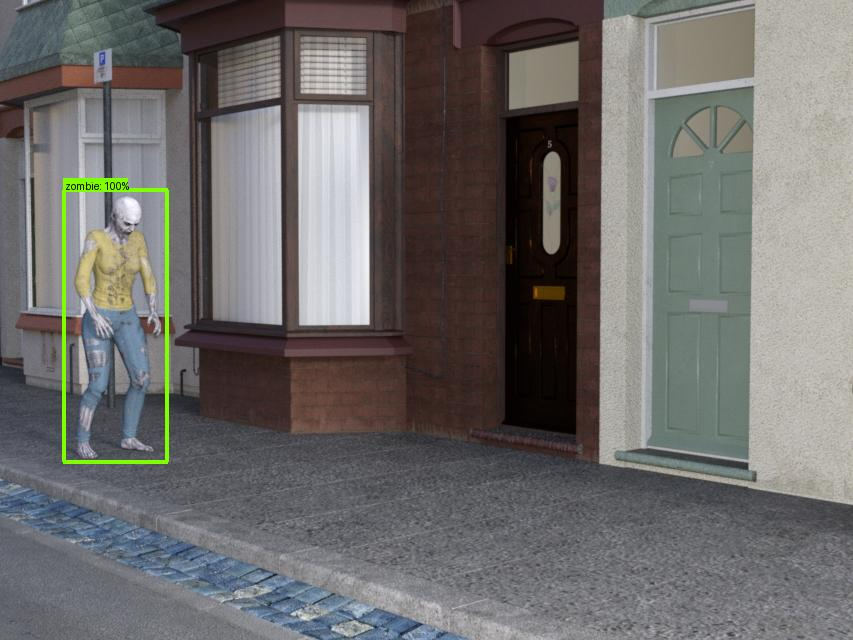


Frame 5


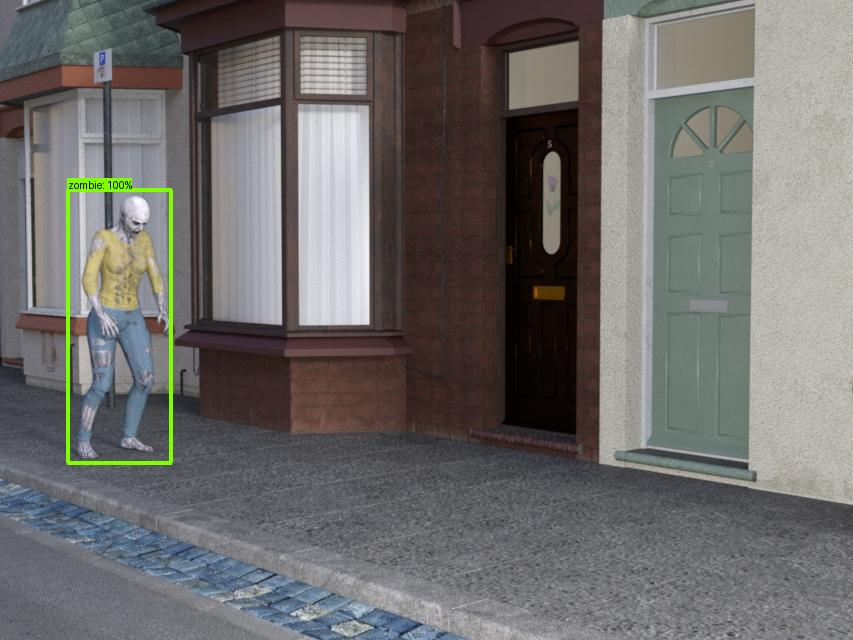


Frame 10


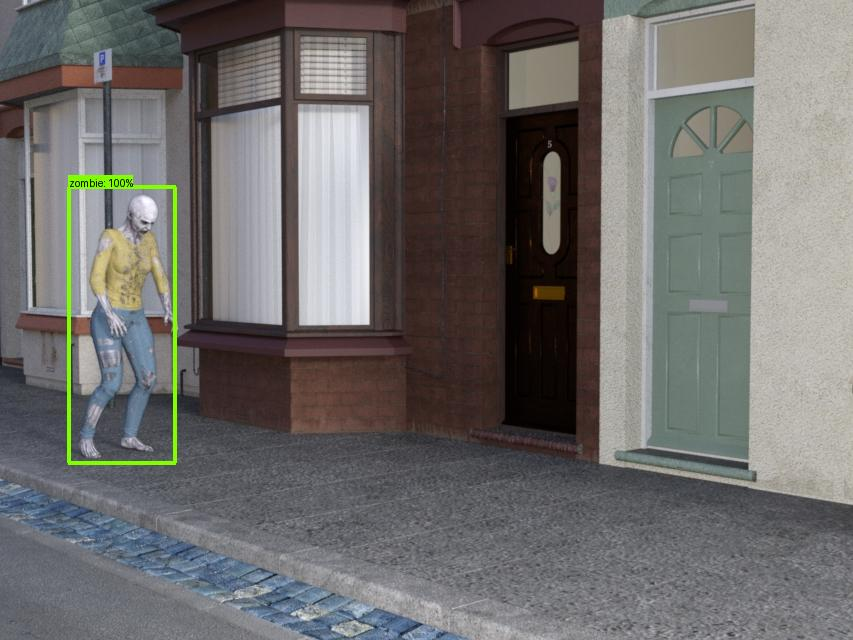

In [73]:
print('Frame 0')
display(IPyImage('./results/gif_frame_000.jpg'))
print()
print('Frame 5')
display(IPyImage('./results/gif_frame_005.jpg'))
print()
print('Frame 10')
display(IPyImage('./results/gif_frame_010.jpg'))

## Create a zip of the zombie-walk images.
I download this to create your own animations

In [74]:
zipf = zipfile.ZipFile('./zombie.zip', 'w', zipfile.ZIP_DEFLATED)

filenames = glob.glob('./results/gif_frame_*.jpg')
filenames = sorted(filenames)

for filename in filenames:
    zipf.write(filename)

zipf.close()

## Create Zombie animation

In [75]:
imageio.plugins.freeimage.download()

!rm -rf ./results/zombie-anim.gif

anim_file = './zombie-anim.gif'

filenames = glob.glob('./results/gif_frame_*.jpg')
filenames = sorted(filenames)
last = -1
images = []

for filename in filenames:
    image = imageio.imread(filename)
    images.append(image)

imageio.mimsave(anim_file, images, 'GIF-FI', fps=10)

Imageio: 'libfreeimage-3.16.0-linux64.so' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/freeimage/libfreeimage-3.16.0-linux64.so (4.6 MB)
Downloading: 8192/4830080 bytes (0.2%)4767744/4830080 bytes (98.7%)4830080/4830080 bytes (100.0%)
  Done
File saved as /root/.imageio/freeimage/libfreeimage-3.16.0-linux64.so.


/tmp/ipython-input-323055697.py:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
